# SDTW on Trainging with Unaligned Dataset
# Setting up Environment

```
$ python -m venv sdtw
$ source sdtw/bin/activate # for linux
$ ./sdtw/Scripts/activate # for windows
$ python.exe -m pip install --upgrade pip # upgrade pip
$ pip install -r requirements.txt
```

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.core.display as ipd
import pandas as pd
import os
import torch
import libfmp.c5

from lib.nn_losses.soft_dtw_cuda import SoftDTW
from lib.nn_models.nn_dchord import dchord_pipeline
from lib.helpers.soft_align import soft_align


# Initalize dChord Network

In [3]:
# Pipeline config

compression_params = {'gamma_init': 1.0,
                      'trainable': True}

temp_smooth_params = {'smoothing_type': 'weighted_sum', 
                      'avg_length': 51, 
                      'weight_init': 'uniform'}

# temp_smooth_params = {'smoothing_type': 'Gaussian', 
#                       'avg_length': 51, 
#                       'sigma_init': 50}

feature_norm_params = {'num_features': 12,
                       'norm': '2', 
                       'threshold': 1e-4}

chord_template_params = {'shared_weights': True, 
                         'initialize_parameters': True, 
                         'normalize_weights': False}

softmax_params = {'tau': 1, 
                  'trainable': False}

In [4]:
model = dchord_pipeline(compression_params=compression_params, temp_smooth_params=temp_smooth_params,
                        feature_norm_params=feature_norm_params, chord_template_params=chord_template_params,
                        softmax_params=softmax_params)

In [5]:
import torchinfo

torchinfo.summary(model, input_size=(1, 1, temp_smooth_params['avg_length'], 12), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
dchord_pipeline                          [1, 1, 51, 12]       [1, 1, 1, 24]        --                   Partial
├─log_compression: 1-1                   [1, 1, 51, 12]       [1, 1, 51, 12]       1                    True
├─temporal_smoothing: 1-2                [1, 1, 51, 12]       [1, 1, 1, 12]        --                   True
│    └─Conv2d: 2-1                       [1, 1, 51, 12]       [1, 1, 1, 12]        51                   True
├─feature_normalization: 1-3             [1, 1, 1, 12]        [1, 1, 1, 12]        --                   --
├─dchord_templates: 1-4                  [1, 1, 1, 12]        [1, 1, 1, 24]        --                   True
│    └─Conv2d: 2-2                       [1, 1, 1, 23]        [1, 2, 1, 12]        24                   True
├─softmax_temperature: 1-5               [1, 1, 1, 24]        [1, 1, 1, 24]        (1)                  False
Total params

In [6]:
normalize = False
sharp = False
sharp_weight_by_avg_alignment_sum = False


criterion = SoftDTW(use_cuda=False, gamma=1.0, dist_func=None, normalize=normalize)

# Preparing Data for Training

In [7]:
nonchord = False
data_basedir = './res/data'

In [8]:
song_dict = {}

song_dict[0] = ['LetItB', 'r',
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original.wav'),
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original_Chords_simplified.csv')]
song_dict[1] = ['HereCo', 'b',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07_Chords_simplified.csv')]
song_dict[2] = ['ObLaDi', 'c',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04_Chords_simplified.csv')]
song_dict[3] = ['PennyL', 'g',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09_Chords_simplified.csv')]

In [9]:
def compute_X_dict(song_selected, version='STFT', details=True, nonchord=False):
    X_dict = {}
    Fs_X_dict = {}
    ann_dict = {}
    x_dur_dict = {}
    chord_labels = libfmp.c5.get_chord_labels(ext_minor='m', nonchord=nonchord)
    for s in song_selected:
        if details is True:
            print('Processing: ', song_dict[s][0])
        fn_wav = song_dict[s][2]
        fn_ann = song_dict[s][3]
#         N = 2048
#         H = 1024
        N = 4096
        H = 2048
        if version == 'STFT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')            # no log compression
        if version == 'CQT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, H=H, version='CQT')                  # no log compression
        if version == 'IIR':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=10, version='IIR')             # no log compression
            
        X_dict[s] = X
        Fs_X_dict[s] = Fs_X
        x_dur_dict[s] = x_dur
        N_X = X.shape[1]
        ann_dict[s] = libfmp.c5.convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=False)
    return X_dict, Fs_X_dict, ann_dict, x_dur_dict, chord_labels
    
song_selected = [0, 1, 2, 3]
#song_selected = [0]
print('===== Computation of STFT-based chromagrams =====')
X_dict_STFT, Fs_X_dict_STFT, ann_dict_STFT, x_dur_dict, chord_labels = compute_X_dict(song_selected, version='STFT', nonchord=nonchord)

===== Computation of STFT-based chromagrams =====
Processing:  LetItB
Processing:  HereCo
Processing:  ObLaDi
Processing:  PennyL


## Create Dataset + Dataloader

In [10]:
class dataset_context(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, params):
        self.inputs = inputs                                # Channels x Time x Chromas
        self.targets = targets                              # Time x Chords
        self.context = params['context']
        self.stride = params['stride']
        
    def __len__(self):
        return (self.inputs.size()[1] - self.context) // self.stride
    
    def __getitem__(self, index):
        index *= self.stride
        half_context = self.context // 2
        index += half_context
        X = self.inputs[:, (index - half_context):(index + half_context + 1), :].type(torch.FloatTensor)
        y = torch.unsqueeze(torch.unsqueeze(self.targets[index, :], 0), 1).type(torch.FloatTensor)
        return X, y

In [11]:
class dataset_context(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, params):
        self.inputs = inputs                                # Channels x Time x Chromas
        self.targets = targets                              # Time x Chords
        self.context = params['context']
        self.stride = params['stride']
        
    def __len__(self):
        return (self.inputs.size()[1] - self.context) // self.stride
    
    def __getitem__(self, index):
        index *= self.stride
        half_context = self.context // 2
        index += half_context
        X = self.inputs[:, (index - half_context):(index + half_context + 1), :].type(torch.FloatTensor)
        y = torch.unsqueeze(torch.unsqueeze(self.targets[index, :], 0), 1).type(torch.FloatTensor)
        return X, y

In [12]:
def create_dataset(data_dict, ann_dict, song_dict, song_indices, dataset_params, dataset_description='train'):
    all_datasets = []
    half_context = dataset_params['context']//2
    
    for s in song_indices:
        inputs = torch.unsqueeze(torch.from_numpy(np.pad(data_dict[s].T, ((half_context, half_context + 1), (0, 0)))), 0)
        targets = torch.from_numpy(np.pad(ann_dict[s][0].T, ((half_context, half_context + 1), (0, 0))))
        curr_dataset = dataset_context(inputs, targets, dataset_params)
        all_datasets.append(curr_dataset)
        
        print(f'- {song_dict[s][0]} added to {dataset_description} set. Length: {len(curr_dataset)} segments')
        
    full_dataset = torch.utils.data.ConcatDataset(all_datasets)     
    print(f'Total number of segments in the {dataset_description} set: {len(full_dataset)}')    
    return full_dataset

In [13]:
train_set_indices = [1, 2]
train_set_params = {'context': temp_smooth_params['avg_length'], 'stride': 1}

train_set = create_dataset(data_dict=X_dict_STFT, 
                           ann_dict=ann_dict_STFT, 
                           song_dict=song_dict, 
                           song_indices=train_set_indices, 
                           dataset_params=train_set_params, 
                           dataset_description='train')

print('\n')

val_set_indices = [3]
val_set_params = {'context': temp_smooth_params['avg_length'], 'stride': 1}

val_set = create_dataset(data_dict=X_dict_STFT, 
                         ann_dict=ann_dict_STFT, 
                         song_dict=song_dict, 
                         song_indices=val_set_indices, 
                         dataset_params=val_set_params, 
                         dataset_description='val')

- HereCo added to train set. Length: 1999 segments
- ObLaDi added to train set. Length: 2034 segments
Total number of segments in the train set: 4033


- PennyL added to val set. Length: 1975 segments
Total number of segments in the val set: 1975


In [14]:
train_loader_params = {'batch_size': 50, 'shuffle': True, 'num_workers': 0}
train_loader = torch.utils.data.DataLoader(train_set, **train_loader_params)
print(f'Training data loader contains {len(train_loader)} mini batches.')

val_loader_params = {'batch_size': 50, 'shuffle': False, 'num_workers': 0}
val_loader = torch.utils.data.DataLoader(val_set, **val_loader_params)
print(f'Validation data loader contains {len(val_loader)} mini batches.')

Training data loader contains 81 mini batches.
Validation data loader contains 40 mini batches.


# Train Pipeline

## Specify which parameters to optimize

In [15]:
print('Trainable parameters:\n')

trainable_parameters = []
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_parameters.append(name)
        print(f"'{name}'") 

Trainable parameters:

'log_compression.log_gamma'
'temporal_smoothing.filter.weight'
'chord_template_params.filter.weight'


Optimization mode $\in \{0, 1, 2 \}$:  
- 0: optimize all trainable parameters 
- 1: optimize **all** trainable parameters **except** the ones specified in `frozen_parameters`
- 2: optimize **only** the parameters specified in `trained_parameters`

(`frozen_parameters` and `trained_parameters` must be lists of strings and a subset of the trainable parameters shown above)

For no optimization at all: set training epochs to zero.

In [16]:
optimization_mode = 0

if optimization_mode == 1:
    frozen_parameters = []           

if optimization_mode == 2:
    trained_parameters = []

In [17]:
if optimization_mode == 0:
    parameters_to_optimize = model.parameters()
    
elif optimization_mode == 1:
    parameters_to_optimize = []

    for name, param in model.named_parameters():
        if not name in frozen_parameters:
            parameters_to_optimize.append(param)
            
elif optimization_mode == 2:
    parameters_to_optimize = []

    for name, param in model.named_parameters():
        if name in trained_parameters:
            parameters_to_optimize.append(param)

### Set Optimizer, Training Parameters and Loss

In [18]:
optim_params = {'lr': 0.01, 'betas': (0.9, 0.999)}
optimizer = torch.optim.Adam(parameters_to_optimize, **optim_params)

In [19]:
training_params = {'device': 'cpu', 'max_epochs': 50}
# training_params = {'device': 'cuda:0', 'max_epochs': 25}

# weights for fighting class imbalance major / minor in training dataset
weight = torch.cat((torch.ones(12), torch.ones(12)))           
# weight = torch.cat((torch.ones(12), 19*torch.ones(12)))

crit = torch.nn.NLLLoss(weight=weight, reduction='mean').to(training_params['device'])  # Categorical CE without log

In [20]:
normalize = False
sharp = False
sharp_weight_by_avg_alignment_sum = False


crit = SoftDTW(use_cuda=False, gamma=1.0, dist_func=None, normalize=normalize)

### Network Training

Train the model. After each training epoch (one iteration over the train dataloader), evaluate performanceon the validation set. We use a variable `best_model` that contains the current best model (the model with the overall lowest validation loss). At the end of the training, the `best_model` ist used for evaluation.

In [ ]:
# reduced version of libdl.training.trainer

from copy import deepcopy

model_pipeline = model.to(training_params['device'])

# for always keeping the best model
best_model = deepcopy(model_pipeline)
best_val_loss = None
best_epoch = None

train_losses = []
val_losses = []

for epoch in range(training_params['max_epochs']):
    # set model to training mode; relevant, e.g., for BatchNorm, Dropout (does not change anything for our model here)
    model_pipeline.train()
    
    with torch.enable_grad():
        accum_loss, n_batches = 0, 0
        for X, y in train_loader:
            X, y = X.to(training_params['device']), y.to(training_params['device'])

            # get model prediction
            y_pred = model_pipeline(X)

            # Remove channel dimension
            y_pred = torch.squeeze(y_pred, 1)  # remove the channel dimension
            y = torch.squeeze(y, 1)  # remove the channel dimension

            loss = crit(y_pred, y )

            # backpropagation + optimization
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            accum_loss += loss.mean().item()
            n_batches += 1
        
    # set model to evaluation mode
    model_pipeline.eval()
    
    with torch.no_grad():    
        accum_loss_val, n_batches_val = 0, 0
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(training_params['device']), y_val.to(training_params['device'])

            y_pred_val = model_pipeline(X_val)
            
            # Remove channel dimension
            y_pred_val = torch.squeeze(y_pred_val, 1)  # remove the channel
            y_val = torch.squeeze(y_val, 1)

            # get loss value
            loss_val = crit(y_pred, y)
            accum_loss_val += loss_val.mean().item()
            n_batches_val += 1        

    train_loss = accum_loss / n_batches
    val_loss = accum_loss_val / n_batches_val
    print(f'Finished epoch {epoch}. Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model_pipeline)
        best_epoch = epoch
        print('    ...saved model')
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)
        
model_pipeline = deepcopy(best_model)
print(f'\nRestored model from epoch {best_epoch}.')

With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
With grad
No grad


ValueError: too many values to unpack (expected 3)

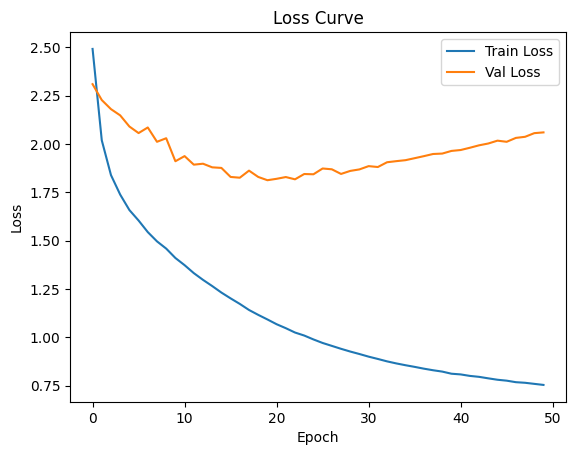

In [ ]:
if len(train_losses) > 1:
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()